In [1]:
#importing libraries
import os, sys, importlib
from importlib import reload
sys.path.insert(1, '../python/data_analysis')

from data_utils import *
from decode_utils import *

importlib.reload(sys.modules['data_utils'])
importlib.reload(sys.modules['decode_utils'])

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import svm
from sklearn.preprocessing import StandardScaler
import sklearn.ensemble
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [2]:
ls ../DataForAlexandre/ChRM04

20200521SumFluoTraceFile.mat  20200524SumFluoTraceFile.mat  Data Structure.txt
20200522SumFluoTraceFile.mat  20200525SumFluoTraceFile.mat
20200523SumFluoTraceFile.mat  20200526SumFluoTraceFile.mat


In [3]:
#specify folder and session of the experiment
folder = 'ChRM04' #ChRM04 or JawsM15 or C57_2_DualTask
session = '20200526' #20200521-6 or 20200605-09 or 20200116-20

In [4]:
#this is the fluorescence data
data = loadmat('../DataForAlexandre/' + folder + '/' + session + 'SumFluoTraceFile' + '.mat')

In [5]:
X_fluo = np.rollaxis(data['C_df'],1,0)
X_fluo_df = np.rollaxis(data['dFF0'],1,0)
X_rates = np.rollaxis(data['S_dec'],1,0)
y_labels = data['Events'].transpose()

In [6]:
print('#trials, #neuron, #frames (time)')
print('data.shape')
print(X_fluo.shape)
print(X_fluo_df.shape)
print(X_rates.shape)

print('labels.shape')
print('#labels, #trials')
print(y_labels.shape)

#trials, #neuron, #frames (time)
data.shape
(192, 1610, 121)
(192, 1610, 121)
(192, 1610, 121)
labels.shape
#labels, #trials
(9, 192)


In [7]:
print('data has nan?')
print(np.isnan(X_fluo).any())
print(np.isnan(X_fluo_df).any())
print(np.isnan(X_rates).any())
print('labels has nan?')
print(np.isnan(y_labels).any())

data has nan?


False
False
False
labels has nan?
False


In [63]:
y_trials = which_trials(y_labels, 'ND_trials')
print(y_trials.shape)
print(y_trials)

(27,)
[ 13  17  22  25  33  45  57  62  65  66  74  77  79  87  96  99 105 117
 126 133 142 148 150 152 171 176 185]


In [64]:
y_S1_trials = which_trials(y_labels, 'S1_ND_trials')
print(y_S1_trials.shape)
print(y_S1_trials)
y_S2_trials = which_trials(y_labels, 'S2_ND_trials')
print(y_S2_trials.shape)
print(y_S2_trials)

(16,)
[ 13  17  33  42  65  66  74  87  96 105 126 142 148 150 176 185]
(16,)
[  3  22  25  45  57  62  77  79  99 117 133 134 152 157 171 190]


In [65]:
X_S2_trials = X_fluo_df[y_S2_trials]
X_S1_trials = X_fluo_df[y_S1_trials]
X_S1_trials = X_S1_trials[0:X_S2_trials.shape[0]]

print(X_S1_trials.shape)
print(X_S2_trials.shape)

X_S1 = bin_data(X_S1_trials,3,3)
print(X_S1.shape)
X_S2 = bin_data(X_S2_trials,3,3)
print(X_S2.shape)

(16, 1610, 121)
(16, 1610, 121)


(16, 1610, 39)


(16, 1610, 39)


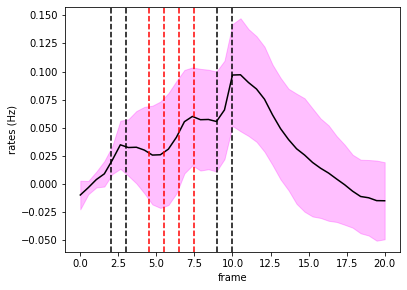

In [66]:
time = np.linspace(0,20,X_S1.shape[2]);
X_window = np.mean(X_S1, axis=1) # avg over neurons 
X_avg = np.mean(X_window,axis=0) # avg over trials 
X_std = np.std(X_window,axis=0) # std over trials

plt.plot(time,X_avg,c='k')
plt.fill_between(time, X_avg - X_std, X_avg + X_std, alpha=0.25, color='magenta')

plt.axvline(x=2, c='k', ls='--') # DPA sample onset 
plt.axvline(x=3, c='k', ls='--')

plt.axvline(x=9, c='k', ls='--') # DPA test onset
plt.axvline(x=10, c='k', ls='--')

plt.axvline(x=4.5, c='r', ls='--') # DRT distractor onset
plt.axvline(x=5.5, c='r', ls='--')

plt.axvline(x=6.5, c='r', ls='--') # DRT cue onset
plt.axvline(x=7.5, c='r', ls='--')

plt.xlabel('frame') ;
plt.ylabel('rates (Hz)') ;

In [67]:
#generating the labels from the length of the trials (samples)
y_S1 = np.repeat(0,int(X_S1.shape[0]))
print(np.unique(y_S1, return_counts=True))

y_S2 = np.repeat(1,int(X_S1.shape[0]))
print(np.unique(y_S2, return_counts=True))

y_S1_S2 = np.concatenate((y_S1, y_S2))
print(y_S1_S2)

(array([0]), array([16]))
(array([1]), array([16]))
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [68]:
#concatenating S1 and S2 by the trials
X_S1_S2 = np.concatenate((X_S1, X_S2), axis=0)
print(X_S1_S2.shape)

(32, 1610, 39)


In [53]:
time_window = 1
split_windows = np.array_split(X_S1_S2, X_S1_S2.shape[2]/time_window, axis=2)

In [54]:
#what has been created?
print('split_area_windows info')
print(type(split_windows))
print('length ' + str(len(split_windows)))
#iterate over the first five element
for i, window in enumerate(split_windows):
    print('element #' + str(i) )
    print(window.shape)

split_area_windows info
<class 'list'>
length 39
element #0
(32, 1610, 1)
element #1
(32, 1610, 1)
element #2
(32, 1610, 1)
element #3
(32, 1610, 1)
element #4
(32, 1610, 1)
element #5
(32, 1610, 1)
element #6
(32, 1610, 1)
element #7
(32, 1610, 1)
element #8
(32, 1610, 1)
element #9
(32, 1610, 1)
element #10
(32, 1610, 1)
element #11
(32, 1610, 1)
element #12
(32, 1610, 1)
element #13
(32, 1610, 1)
element #14
(32, 1610, 1)
element #15
(32, 1610, 1)
element #16
(32, 1610, 1)
element #17
(32, 1610, 1)
element #18
(32, 1610, 1)
element #19
(32, 1610, 1)
element #20
(32, 1610, 1)
element #21
(32, 1610, 1)
element #22
(32, 1610, 1)
element #23
(32, 1610, 1)
element #24
(32, 1610, 1)
element #25
(32, 1610, 1)
element #26
(32, 1610, 1)
element #27
(32, 1610, 1)
element #28
(32, 1610, 1)
element #29
(32, 1610, 1)
element #30
(32, 1610, 1)
element #31
(32, 1610, 1)
element #32
(32, 1610, 1)
element #33
(32, 1610, 1)
element #34
(32, 1610, 1)
element #35
(32, 1610, 1)
element #36
(32, 1610, 1)

In [55]:
#defining the time vector
time = np.linspace(0, X_rates.shape[2]/6, num=len(split_windows))
print(time)

[ 0.          0.53070175  1.06140351  1.59210526  2.12280702  2.65350877
  3.18421053  3.71491228  4.24561404  4.77631579  5.30701754  5.8377193
  6.36842105  6.89912281  7.42982456  7.96052632  8.49122807  9.02192982
  9.55263158 10.08333333 10.61403509 11.14473684 11.6754386  12.20614035
 12.73684211 13.26754386 13.79824561 14.32894737 14.85964912 15.39035088
 15.92105263 16.45175439 16.98245614 17.51315789 18.04385965 18.5745614
 19.10526316 19.63596491 20.16666667]


In [56]:
cv = 5
model_name = 'svm_linear'
scoring = {'f_score S1': make_scorer(f1_score, average = None, labels = [0]),
       'f_score S2': make_scorer(f1_score, average = None, labels = [1])}

clf = svm.LinearSVC() #svm.SVC(kernel='rbf', random_state=1, gamma=.001, C=1)

In [227]:
S1_f_score, S2_f_score, S1_f_score_std, S2_f_score_std = cross_validate_clf(split_windows, y_S1_S2, cv, scoring, clf) ;

In [228]:
print(S1_f_score)
print('S1_f_score')
print('\nList lenght (f_score) ' + str(len(S1_f_score)))

[0.1        0.1        0.16666667 0.1        0.16666667 0.11666667
 0.18333333 0.         0.1        0.11666667 0.11666667 0.16666667
 0.16666667 0.15       0.11666667 0.11666667 0.05       0.05
 0.16666667 0.16666667 0.05       0.18333333 0.2        0.16666667
 0.11666667 0.15       0.1        0.15       0.1        0.18333333
 0.05       0.1        0.16666667 0.11666667 0.15       0.05
 0.21666667 0.1        0.11666667 0.16666667 0.1        0.16666667
 0.11666667 0.18333333 0.1        0.05       0.1        0.1
 0.16666667 0.16666667 0.05       0.13333333 0.1        0.1
 0.11666667 0.11666667 0.16666667 0.05       0.18333333 0.1
 0.1        0.21666667 0.16666667 0.05       0.18333333 0.11666667
 0.16666667 0.16666667 0.18333333 0.16666667 0.2        0.13
 0.1        0.18333333 0.16666667 0.1        0.15       0.18333333
 0.16666667 0.1        0.16666667 0.16666667 0.16666667 0.1
 0.1        0.1        0.18333333 0.16666667 0.11666667 0.11666667
 0.05       0.11666667 0.16666667 0.16666

In [229]:
#sample of the results
print('S2_f_score')
print(S2_f_score)
print('\nList lenght (f_score) ' + str(len(S2_f_score)))

S2_f_score
[0.2        0.16666667 0.1        0.16666667 0.1        0.11666667
 0.05       0.23333333 0.16666667 0.11666667 0.11666667 0.1
 0.1        0.15       0.11666667 0.11666667 0.18333333 0.18333333
 0.1        0.1        0.18333333 0.05       0.15       0.1
 0.11666667 0.15       0.16666667 0.15       0.16666667 0.05
 0.18333333 0.24666667 0.1        0.11666667 0.15       0.18333333
 0.1        0.16666667 0.11666667 0.11666667 0.16666667 0.1
 0.11666667 0.05       0.16666667 0.18333333 0.16666667 0.16666667
 0.1        0.15       0.18333333 0.1        0.16666667 0.16666667
 0.11666667 0.11666667 0.1        0.18333333 0.05       0.16666667
 0.16666667 0.1        0.1        0.18333333 0.05       0.11666667
 0.1        0.1        0.05       0.1        0.1        0.16666667
 0.16666667 0.05       0.1        0.16666667 0.15       0.05
 0.1        0.16666667 0.1        0.1        0.1        0.16666667
 0.16666667 0.16666667 0.05       0.1        0.11666667 0.11666667
 0.18333333 0.116

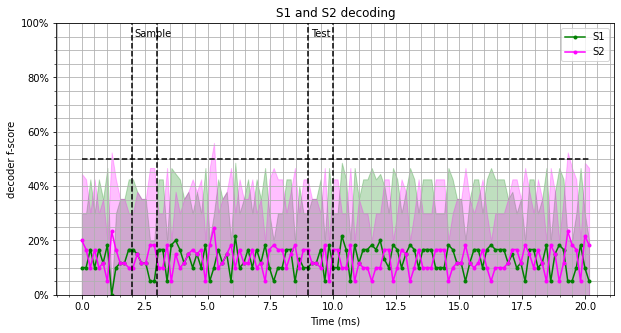

In [230]:
plot_decoding_results(S1_f_score, S2_f_score, S1_f_score_std, S2_f_score_std, time)

In [382]:
from sklearn.model_selection import train_test_split
from sklearn import svm
X = np.reshape((X_S1_S2), (X_S1_S2.shape[0], X_S1_S2.shape[1]* X_S1_S2.shape[2]))
y = y_S1_S2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8571428571428571

In [383]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.28)


In [384]:
from sklearn import metrics
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.68 (+/- 0.29)


39
39


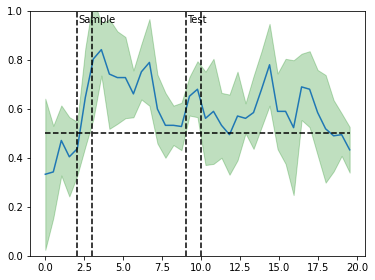

In [386]:
X = X_S1_S2
time_window = 1
split_windows = np.array_split(X, X.shape[2]/time_window, axis=2)
scoring = {'score S1': make_scorer(accuracy_score, labels = [0]),
           'score S2': make_scorer(accuracy_score, labels = [1])}

#out = cross_validate(clf, X, y, scoring=scoring, cv=cv, return_train_score=False, n_jobs=-1)
score = [] 
score_std = [] 

for X_window in split_windows:
    X_window  = np.reshape((X_window), (X_window.shape[0], X_window.shape[1]* X_window.shape[2]))
    X_window = StandardScaler().fit_transform(X_window)
    out = cross_validate(clf,X_window,y,cv=5)

    for key, value in out.items(): 
        if(key=='test_score'):
            #print(key)
            #print(value)
            score.append(np.average(value))
            score_std.append(np.std(value))
            
score = np.array(score)
score_std = np.array(score_std)

time = np.linspace(0, X.shape[2]/2, num=len(split_windows))
print(len(time))
print(len(score))
plt.plot(time, score)
plt.fill_between(time, score - score_std, score + score_std, alpha=0.25, color='green')

y_for_chance = np.repeat(0.50, len(score) )
plt.plot(time, y_for_chance, '--', c='black')
plt.ylim([0, 1])
plt.axvline(x=2, c='black', linestyle='dashed')
plt.axvline(x=3, c='black', linestyle='dashed')
# vertical lines for cue and stimulus
plt.text(2.1, 0.95, 'Sample', rotation=0)
plt.text(9.1, 0.95, 'Test', rotation=0)
plt.axvline(x=9, c='black', linestyle='dashed')
plt.axvline(x=10, c='black', linestyle='dashed')


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

In [69]:
y = y_S1_S2
X = X_S1_S2
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
#clf = make_pipeline(StandardScaler(), svm.LinearSVC)
time_gen = GeneralizingEstimator(clf, n_jobs=-1, scoring='accuracy', verbose=True)
scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=-1)
scores = np.mean(scores, axis=0)
scores_std= np.std(scores, axis=0)

[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


[Parallel(n_jobs=56)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.1s
[Parallel(n_jobs=56)]: Done   5 out of   5 | elapsed:    7.6s finished


(39,)
(39,)
(39,)


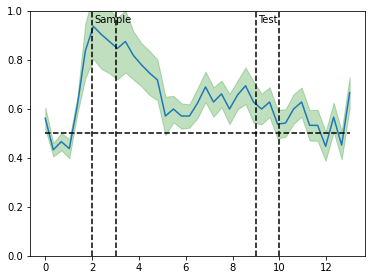

In [70]:
time = np.linspace(0, scores.shape[1]/3, num=scores.shape[1] )
print(time.shape)
diag_scores = np.diag(scores)
diag_scores_std = scores_std
print(diag_scores.shape)
print(diag_scores_std.shape)

plt.plot(time, diag_scores)
plt.fill_between(time, diag_scores - diag_scores_std, diag_scores + diag_scores_std, alpha=0.25, color='green')

y_for_chance = np.repeat(0.50, len(diag_scores) )
plt.plot(time, y_for_chance, '--', c='black')
plt.ylim([0, 1])
plt.axvline(x=2, c='black', linestyle='dashed')
plt.axvline(x=3, c='black', linestyle='dashed')
# vertical lines for cue and stimulus
plt.text(2.1, 0.95, 'Sample', rotation=0)
plt.text(9.1, 0.95, 'Test', rotation=0)
plt.axvline(x=9, c='black', linestyle='dashed')
plt.axvline(x=10, c='black', linestyle='dashed')

In [71]:
dscores= scores - np.mean(scores,axis=0)
dscores.shape

(39, 39)

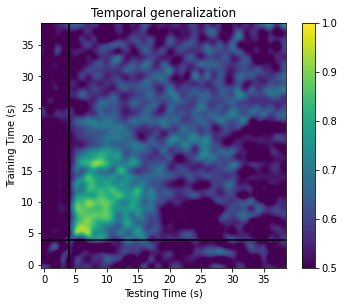

In [72]:
ig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', vmin=.5, vmax=1)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(4, color='k')
ax.axhline(4, color='k')
plt.colorbar(im, ax=ax)

In [ ]:
......ChRM04: ND, D1, D2

In [39]:
...JawsM15: ND, D1, D2

SyntaxError: invalid syntax (<ipython-input-39-08011ab53407>, line 1)